Simple efficiency example
====

Let's define some PDFs and an efficiency that all look like step functions:

$p_1(x) = 1, x < 0; 0.1, x > 0$  
$p_2(x) = 0.1, x < 0; 1, x > 0$

$\epsilon(x) = 1, x < 0; 0.5, x > 0$


In [1]:
import numpy as np
import matplotlib.pyplot as plt

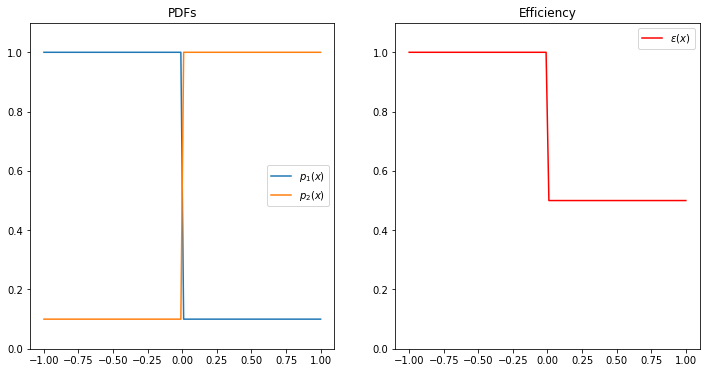

In [2]:
# Define and plot efficiency and pdfs
pdf_domain = -1.0, 1.0
pdf_range = 0.0, 1.1

def p1(x):
    if x < 0:
        return 1
    return 0.1

def p2(x):
    if x < 0:
        return 0.1
    return 1

def e(x):
    if x < 0:
        return 1
    return 0.5

domain = np.linspace(pdf_domain[0], pdf_domain[1], 100)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(domain, [p1(x) for x in domain], label=r"$p_1(x)$")
ax[0].plot(domain, [p2(x) for x in domain], label=r"$p_2(x)$")
ax[0].set_title("PDFs")
ax[0].set_ylim((0.0, 1.1))

ax[1].plot(domain, [e(x) for x in domain], label=r"$\epsilon(x)$", color="r")
ax[1].set_title("Efficiency")
ax[1].set_ylim((0.0, 1.1))

ax[0].legend()
ax[1].legend()
plt.show()

If we take random samples of size $N_1$ and $N_2$ from $p_1$ and $p_2$ respectively, we would expect to find
$\frac{20}{21}N_1 + \frac{1}{6}N_2$ samples in the region $x < 0$ and $\frac{5}{6}N_2 + \frac{1}{21}N_1$ samples in the region $x > 0$*.

(The efficiency $\epsilon(x)$ means it is not immediately obvious (to me) what the coefficients in the above equation should be, but you can work it out by enforcing that you have N1 total events from p1, and events at x>0 have a 50% chance of being thrown away by the efficiency function).

*This isn't actually that important, so don't worry about it too much.


In [3]:
rng = np.random.default_rng()

def sample(N, pdf):
    """
    Use accept-reject sampling to get N samples from pdf
    
    slow
    
    """
    if N == 0:
        return []
    
    points = np.zeros(N)
    num_generated = 0

    while num_generated < N:
        # Generate a point
        x = pdf_domain[0] + (pdf_domain[1] - pdf_domain[0]) * rng.random()
        y = pdf_range[0] + (pdf_range[1] - pdf_range[0]) * rng.random()

        if y < pdf(x):
            points[num_generated] = x
            num_generated += 1

    return points

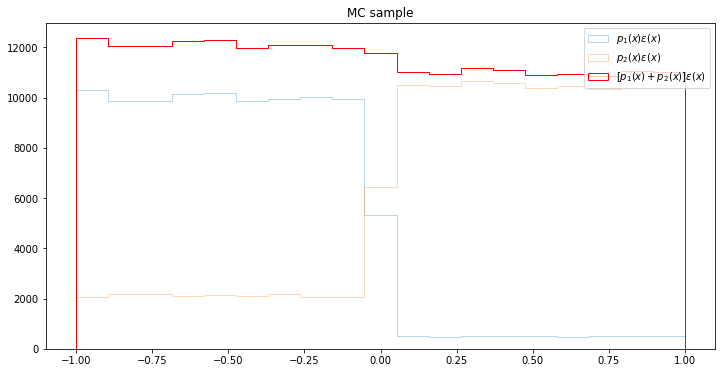

In [4]:
# Take samples from both p1(x) and p2(x), remembering to take the efficiency into account
N1, N2 = 100000, 120000

# Take samples from PDFs modulated by the efficiency and combine them
p1_sample = sample(N1, lambda x: p1(x) * e(x))
p2_sample = sample(N2, lambda x: p2(x) * e(x))
combined_sample = np.concatenate((p1_sample, p2_sample))

# Plot the combined sample
kw = {"bins": np.linspace(-1, 1, 20), "histtype": "step"}
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.hist(p1_sample, **kw, label=r"$p_1(x)\epsilon(x)$", alpha=0.3)
ax.hist(p2_sample, **kw, label=r"$p_2(x)\epsilon(x)$", alpha=0.3)
ax.hist(combined_sample, **kw, label="$[p_1(x) + p_2(x)]\epsilon(x)$", color="r")
ax.legend()
ax.set_title("MC sample")
plt.show()

Now, let's try to find a PDF describing the combined distribution of points from both $p_1$ and $p_2$.


We think it should be described by $p(x) = I_1p_1(x) + I_2p_2(x)$, with

$I_1 = \sum_i^{N_1}1/p_1(x_i)$ etc.

In our case this is $p(x) = \frac{10}{7}N_1p_1(x) + \frac{5}{2}N_2p_2(x)$. 

NB: We can scale the $I$ coefficients by a constant in order to make the PDF sensible.

Postulate now that the "true" PDF describing our combined distribution above is $p(x)\epsilon(x)$; we should be able to find the efficiency by taking a sample from $p(x)$:

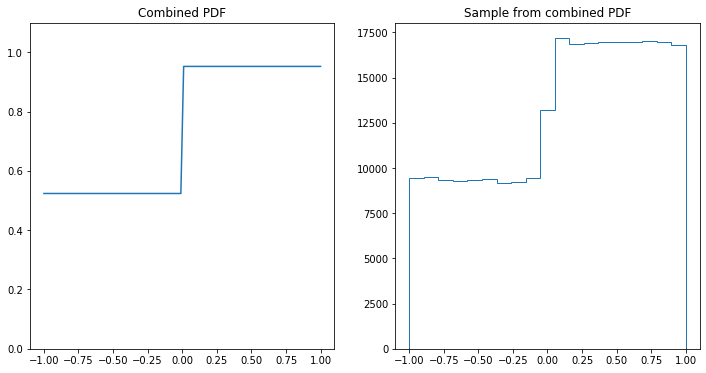

In [5]:
scale_factor = 1.5 * (N1 + N2)
def combined_pdf(x):
    return 10.0 * N1 * p1(x) / (7.0 * scale_factor) + 5.0 * N2 * p2(x) / (2.0 * scale_factor)

model = sample(250000, combined_pdf)

fig, ax = plt.subplots(1, 2, figsize=(12.0, 6.0))
ax[0].plot(domain, [combined_pdf(x) for x in domain])
ax[0].set_ylim((0.0, 1.1))
ax[0].set_title("Combined PDF")


ax[1].hist(model, **kw)
ax[1].set_title("Sample from combined PDF")

plt.show()

Now we just need to compare our sample from the combined PDF to the combined MC sample, and see if we get the right efficiency out.  
To do that, let's find the ratio of points in the regions $x > 0$ and $x < 0$:

In [6]:
mc_neg = np.sum(combined_sample < 0)
mc_pos = np.sum(combined_sample > 0)

model_neg = np.sum(model < 0)
model_pos = np.sum(model > 0)

print(f"MC:\t{mc_neg}\t{mc_pos}")
print(f"model:\t{model_neg}\t{model_pos} in regions x < 0 and x > 0")


MC:	115410	104590
model:	88784	161216 in regions x < 0 and x > 0


We don't actually care about (read: we can't calculate) absolute efficiency; we only care about the shape of the efficiency. i.e. the relative efficiency between the regions x > 0 and x < 0.

We expect to find that the efficiency for $x > 0$ is half the efficiency for $x < 0$.

In [7]:
ratio_neg = mc_neg / model_neg
ratio_pos = mc_pos / model_pos

print(f"\nx<0 efficiency:\t{ratio_neg}\nx>0 efficiency:\t{ratio_pos}")

print(f"\nratio:\t{ratio_pos / ratio_neg}; expect this to be 0.5")


x<0 efficiency:	1.2998963777257164
x>0 efficiency:	0.6487569472012703

ratio:	0.4990835872135654; expect this to be 0.5


It looks like we've found the right efficiency...!